# Cross-checking Classical Simulation

In this notebook, we will demonstrate how classical reversible logic bloqs can combine
the quantum simulation and classical simulation protocols to cross check their logic. 

We'll use a provided library function to wrap a bloq in allocations and de-allocations
following the bloq's classical logic so that when we contract the resultant tensor network
we get a value of `1` (corresponding to a normalized, unitary universe) if everything
checks out.

The function `flank_with_classical_vectors` will set up the [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) we need.

In [1]:
from qualtran.drawing import show_bloq
from qualtran.simulation.xcheck_classical_quimb import flank_with_classical_vectors

import numpy as np

## `XGate`

The X gate flips a given bit. 

In [2]:
from qualtran.bloqs.basic_gates import XGate
x = XGate()

If we start in the `0` basis state, we better end up in the `1` basis state.
`flank_wht_classical_vectors` will use the classical simulation protocol to determine
the correct output state given the provided input state, and the `assert tensor_contract()`
will use the quantum simulation (tensor network) protocol to check if the input/output
pair is valid for the bloq.

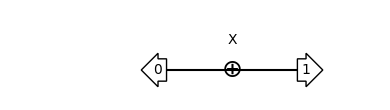

In [3]:
x_tt = flank_with_classical_vectors(x, {'q': 0})

assert x_tt.tensor_contract() == 1.0
show_bloq(x_tt, type='musical_score')

`flank_with_classical_vectors` will use the classical simulation protocol to determine the correct output values. We can override them with our own. Below, we make a [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) where the inputs and outputs are both the `0` vector. This doesn't match the expected behavior of the X gate, so the tensor network contracts to zero.

In [4]:
result = flank_with_classical_vectors(x, in_vals={'q':0}, out_vals={'q': 0}).tensor_contract()
if result == 0.0:
    print('Tensor contracted to 0. The universe has been annihilated.')

Tensor contracted to 0. The universe has been annihilated.


## `CNOT`

We can check other bloqs that support both classical simulation and quantum simulation. In this notebook, we've hardcoded some input values but you could try random inputs or use `itertools.product` to check all possible inputs.

In [5]:
from qualtran.bloqs.basic_gates import CNOT
cnot = CNOT()

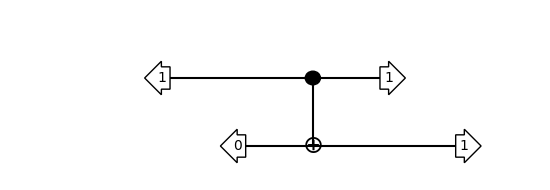

In [6]:
cnot_tt = flank_with_classical_vectors(cnot, {'ctrl': 1, 'target': 0})

assert cnot_tt.tensor_contract() == 1.0
show_bloq(cnot_tt, type='musical_score')

## `Toffoli`

In [7]:
from qualtran.bloqs.basic_gates import Toffoli
tof = Toffoli()

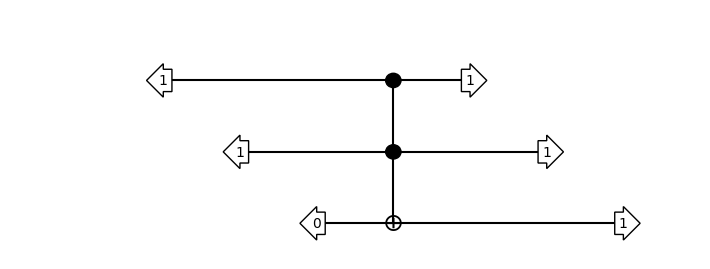

In [8]:
tof_tt = flank_with_classical_vectors(tof, {'ctrl': [1, 1], 'target': 0})

assert tof_tt.tensor_contract() == 1.0
show_bloq(tof_tt, type='musical_score')

## `Add`

In [9]:
from qualtran import QUInt
from qualtran.bloqs.arithmetic import Add
add = Add(QUInt(bitsize=5))

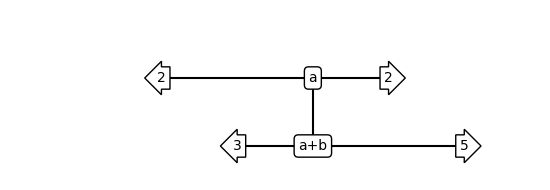

In [10]:
add_tt = flank_with_classical_vectors(add, {'a': 2, 'b': 3})
show_bloq(add_tt, type='musical_score')

Since `Add` is composed of other bloqs, we can contract the factorized network that comes from the "flattened" circuit.

(<Figure size 2000x279.279 with 1 Axes>, <Axes: >)

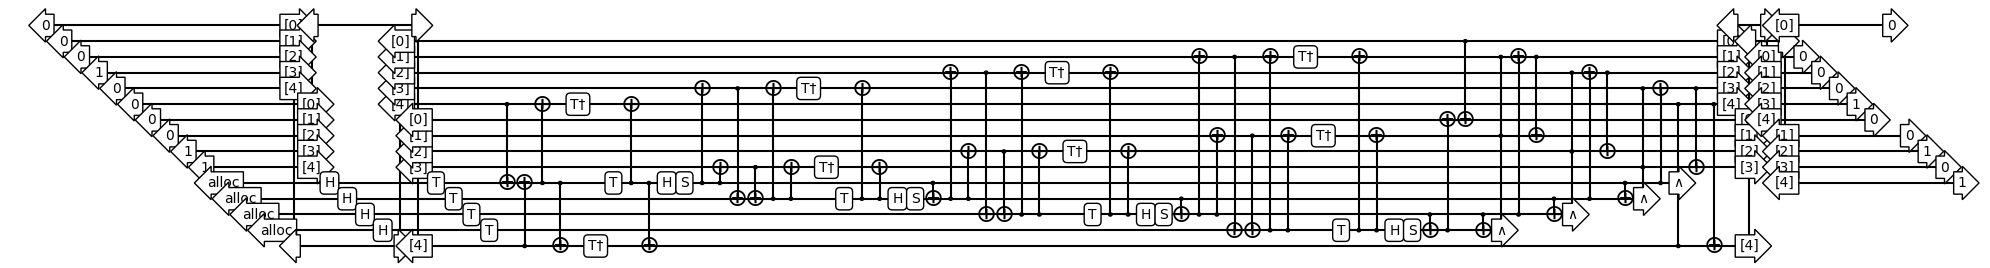

In [11]:
add_flat = add_tt.as_composite_bloq().flatten()

from qualtran.drawing import get_musical_score_data, draw_musical_score
draw_musical_score(get_musical_score_data(add_flat), max_width=20, max_height=100)

In [12]:
np.testing.assert_allclose(add_tt.tensor_contract(), 1.0)
np.testing.assert_allclose(add_flat.tensor_contract(), 1.0)

### Large bitsize

Since we're using Quimb to find an efficient contraction ordering, we can handle large-width, bounded-depth tensor networks.

In [13]:
add_large = Add(QUInt(bitsize=32))
add_large_tt = flank_with_classical_vectors(add_large, {'a': 5555, 'b': 6666})
add_large_flat = add_large_tt.flatten()

from qualtran.simulation.tensor import cbloq_to_quimb
tn = cbloq_to_quimb(add_large_flat)

print(f"We only use {tn.contraction_width()} qubit's worth of RAM for a {add_large.signature.n_qubits()}-qubit gate.")
tn.contract()

We only use 6.0 qubit's worth of RAM for a 64-qubit gate.


0.999999999999995